# Importing the necessary libraries

In [ ]:
import os
import pandas as pd
import math
import librosa
import librosa.display
import numpy as np
from statistics import mean
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from keras.wrappers.scikit_learn import KerasClassifier

# Setting global parameters

In [ ]:
DATASET_PATH = "dataset"
SAMPLE_RATE = 22050
TRACK_DURATION = 8 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
FRAME_SIZE = 1024
HOP_LENGTH = 512

# defining a function for extracting the features (MFCC, ZCR)


In [ ]:
def get_features(dataset_path, features, num_mfcc=13, n_fft=2048, num_segments=3):

  samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  num_mfcc_vec_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)
  data    = []
  labels  = []
  
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
    

    if features == 'all':

      for f in filenames:
        
        #get the file path and load it to librosa
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        #processing every segment of the file
        for d in range(num_segments):
          
          #get the labels from file names
          labels.append(f[-6:-4])

          #get the start and finish sample for the segment
          start = samples_per_segment * d
          finish = start + samples_per_segment

          #extract mfccs
          mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=HOP_LENGTH)
          mfcc = mfcc.T

          zcr = librosa.feature.zero_crossing_rate(signal[start:finish], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0] 
          zcr = zcr[..., np.newaxis]

          

          if len(mfcc) == num_mfcc_vec_per_segment:
            features = np.append(mfcc.tolist(), zcr, axis=1)
            data.append(features.tolist())

    elif features == 'mfcc':
      for f in filenames:
        
        #get the file path and load it to librosa
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        #processing every segment of the file
        for d in range(num_segments):
          
          #get the labels from file names
          labels.append(f[-6:-4])

          #get the start and finish sample for the segment
          start = samples_per_segment * d
          finish = start + samples_per_segment

          #extract mfccs
          mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=HOP_LENGTH)
          mfcc = mfcc.T        

          if len(mfcc) == num_mfcc_vec_per_segment:
            data.append(mfcc.tolist())

    elif features == 'zcr':
      for f in filenames:
        
        #get the file path and load it to librosa
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        #processing every segment of the file
        for d in range(num_segments):
          
          #get the labels from file names
          labels.append(f[-6:-4])

          #get the start and finish sample for the segment
          start = samples_per_segment * d
          finish = start + samples_per_segment

          #extract zcr
          zcr = librosa.feature.zero_crossing_rate(signal[start:finish], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0] 
          zcr = zcr[..., np.newaxis]


          if len(zcr) == num_mfcc_vec_per_segment:
            data.append(zcr.tolist())
    else:
      raise Exception('the "features" argument should be "mfcc", "zcr", or "all" !')

  return data, labels

In [ ]:
X, y = get_features(DATASET_PATH, features='all')
X = np.array(X)
y = np.array(y)

In [ ]:
num_of_classes = np.unique(y).size

In [ ]:
X.shape

(120, 115, 14)

# Preparing the dataset 

In [ ]:
'''#transforming the labels from [24, 25, ... , 35] to [0,...,9]
unique_y = np.unique(y) 
inv_map = {v: k for k, v in dict(enumerate(unique_y)).items()}
y = np.vectorize(inv_map.get)(y)'''

'#transforming the labels from [24, 25, ... , 35] to [0,...,9]\nunique_y = np.unique(y) \ninv_map = {v: k for k, v in dict(enumerate(unique_y)).items()}\ny = np.vectorize(inv_map.get)(y)'

In [ ]:
y = np.array(list(map(int, y)))

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [ ]:
def prepare_datasets(test_size, X, y):
    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
   
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_datasets(0.2, X, y)


In [ ]:
X_test.shape

(24, 115, 14, 1)

# Defining a function for plotting the CNN results

In [ ]:
def plot_history(history):
    
    fig, axs = plt.subplots(2, figsize=(15, 15))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

# Definig a function for building the model

In [ ]:
num_of_classes

10

In [ ]:

shape = {
      'number_of_conv_layers' : 4,
      'num_neurons_per_layer' : [512,128,64,32],
      'conv_shape': [(5,5), (3,3), (2,2), (2,2)],
      'pooling_shape': [(3,3), (3,3), (2,2), (2,2)],
      'pooling_stride': [(1,1), (2,2), (2,2), (2,2)],
      'dropout_percentage': 0.3,
      'dense_layer_neurons': 64,
      'output_layer': num_of_classes
}


In [ ]:
'''
shape = {
      'number_of_conv_layers' : 3,
      'num_neurons_per_layer' : [512,128,64],
      'conv_shape': [(5,5), (3,3), (2,2)],
      'pooling_shape': [(3,3), (3,3), (2,2)],
      'pooling_stride': [(1,1), (2,2), (2,2)],
      'dropout_percentage': 0.3,
      'dense_layer_neurons': 64,
      'output_layer': num_of_classes
}
'''

"\nshape = {\n      'number_of_conv_layers' : 3,\n      'num_neurons_per_layer' : [512,128,64],\n      'conv_shape': [(5,5), (3,3), (2,2)],\n      'pooling_shape': [(3,3), (3,3), (2,2)],\n      'pooling_stride': [(1,1), (2,2), (2,2)],\n      'dropout_percentage': 0.3,\n      'dense_layer_neurons': 64,\n      'output_layer': num_of_classes\n}\n"

In [ ]:
def build_model(architecture = shape, activation = 'relu', optimizer = 'adam'):

  model = keras.Sequential()

  for i in range(architecture['number_of_conv_layers']):
    model.add(keras.layers.Conv2D(architecture['num_neurons_per_layer'][i], architecture['conv_shape'][i], activation=activation))
    model.add(keras.layers.MaxPooling2D(architecture['pooling_shape'][i],  strides= architecture['pooling_stride'][i], padding='same'))
    model.add(keras.layers.BatchNormalization())


  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(architecture['dense_layer_neurons'], activation=activation))
  model.add(keras.layers.Dropout(architecture['dropout_percentage']))
  model.add(keras.layers.Dense(architecture['output_layer'], activation='softmax'))

  model.compile( 
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

  return model

In [ ]:
model = build_model()

# Grid search for CNN


In [ ]:
batch_size = [10, 20, 30, 40]
epochs = [10, 50, 100]

#learn_rate = [0.0001, 0.001, 0.01, 0.1, 0.2]
optimizer = ['SGD', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, activation=activation )


# create model
GSmodel = KerasClassifier(build_fn=build_model)

grid = GridSearchCV(estimator=GSmodel, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)


Epoch 1/10


In [ ]:
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# K-fold for the CNN

In [ ]:
def train_Kfold_split(n_splits, architecture):

  skf = StratifiedKFold(n_splits = n_splits, random_state = 42, shuffle = True) 
  acc_per_fold = []
  loss_per_fold = []
  fold_no  = 1
  for train_index, test_index in skf.split(X_train, y_train):   
    
    model = build_model(architecture)
    
    history = model.fit(X_train[train_index], y_train[train_index], batch_size=10, epochs=100, verbose=0)
    
    # Generate generalization metrics
    scores = model.evaluate(X_train[test_index], y_train[test_index], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1
  
  return mean(acc_per_fold)

In [ ]:
score = train_Kfold_split(10, architecture=shape)

In [ ]:
score

74.22222316265106

# Final CNN model


In [ ]:
CNN = build_model(shape)
history = model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=1, validation_data = (X_test, y_test))

In [ ]:
y_pred = CNN.predict(X_test)
y_pred[23].sum()

#print("Accuracy:",metrics.accuracy_score(y_test, pred))

1.0

# Plotting the CNN results



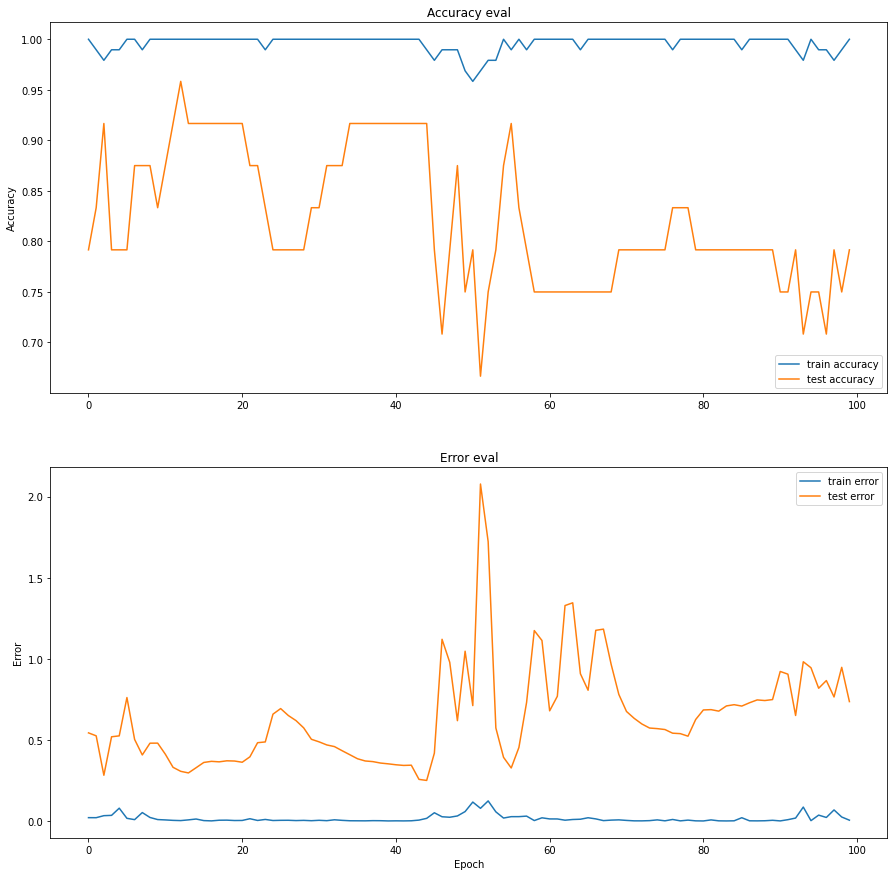

In [ ]:
plot_history(history)

# Resplitting and flattening the data 

In [ ]:
flatX_train = X_train.reshape(X_train.shape[0], -1)
flatX_test = X_test.reshape(X_test.shape[0], -1)


In [ ]:
flatX_train.shape

(96, 1610)

# KNN + grid search

In [ ]:
k_range = list(range(1,50))
weight_options = ["uniform", "distance"]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
p = [1, 2]
param_grid = dict(n_neighbors = k_range, weights = weight_options, algorithm= algorithm, p=p)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy',verbose=0)
grid.fit(flatX_train,y_train)




In [ ]:
print (grid.best_params_)

In [ ]:
tuned_knn = KNeighborsClassifier(algorithm='auto', n_neighbors=2, weights='uniform')
tuned_knn.fit(flatX_train,y_train)

In [ ]:
pred=tuned_knn.predict(flatX_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.8333333333333334


# Random forest

In [ ]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(1,50)),
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(flatX_train,y_train)
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 100}

In [ ]:
tuned_rfc = RandomForestClassifier(n_estimators=100, max_features='log2', max_depth=6, criterion='gini')

In [ ]:
tuned_rfc.fit(flatX_train,y_train)

In [ ]:
pred=tuned_rfc.predict(flatX_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.7916666666666666




## Gaussian Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(flatX_train,y_train)
y_pred=tuned_rfc.predict(flatX_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7916666666666666
